In [43]:
using PyPlot
using Statistics
using LinearAlgebra

In this notebook, we present a simulation that was intended to illustrate the capabilities of projection onto the $\zeta-$ domain, which was proposed as an online drift compensation method in the paper "A probabilistic Approach for Drift Compensation of Gas Sensor Data". 

For this, we simulate an environment where, in each day, 50 measurements of an array containing two sensors are collected from four possible gases. In this environment, gas emissions are due to activities that follow each other according to a Markovian dependence, thus the gas sampling sequence follows a Markov process. 

We first simulate this process for 120 in a drift-free scenerio, where each gas stimulates the sensors in a specific way, such that it is the gas can be easily recognized from the sensors' response. Next, we introduce a time and gas-dependent drift pattern for each sensor, in a way such that the gas recognition capabilities of the raw measurement is comprimised, but monotonocity assumption (with respect to each pair of gases, but not to the time variable) is respected. We then show that the representation in the $\zeta-$ domain preserves the class separability in both scenarios, and can thus be immune to drift. 


The results of this simulation were presented as a toy example in the manuscript.

In [ ]:
######FUNCTIONS#######

#This function draws a sample from a probability mass function and will be used to decide which gas will be sampled at each moment
function draw(pmf) 
    cdf = cumsum(pmf);
    aux = rand();
    x = minimum(findall(a-> a>aux, cdf));
    return x
end

#This function will be to simulate a sequence of n observations from a markov process
function simulate_markov(P, n) #P = transition matrix; n = number of instances
    ns = size(P,1); #number of states
    sequence = Int64.(zeros(n));
    sequence[1] = argmax(rand(ns));
    for i in 2:n
        sequence[i] = draw(P[sequence[i-1], :])
    end
    return sequence
end

#=This function will be used to collect from a given gas at time t (in days). Each sample will be composed as the sum of 
a gas-dependent constant vector (which is driftless response to that gas), a gas and time-dependent drift vector (to account
for drift patterns that dinamically change over time and are different for each target gas) and a noise vector.=#
function sample(gas, t) 
    std = 0.07;

    if gas == 1
        mu1 = 4.3;
        mu2 = 2.9;
        s1 = std*randn()+mu1;
        s2 = std*randn()+mu2;
        if t<60
            s1 = s1 - 0.0004*t^2;
            s2 = s2 + 0.02*t;
        end

        if t >=60
            s1 = s1 - 0.0004*59^2 + (t-59)*0.018;
            s2 = s2 + 0.02*59 - (t-59)*0.025;
        end
    end

    if gas == 2
        mu1 = 3.9;
        mu2 = 1.9;
        s1 = std*randn()+mu1;
        s2 = std*randn()+mu2;
        if t<60
            s1 = s1 - 0.00039*t^2;
            s2 = s2 + 0.02*t;
        end
        
        if t>=60
            s1 = s1 - 0.00039*59^2 + (t-59)*0.021;
            s2 = s2 + 0.02*59 - (t-59)*0.01;
        end
    end

    if gas == 3 
        mu1 = 1.9
        mu2 = 4.0
        s1 = std*randn()+mu1;
        s2 = std*randn()+mu2;
        if t<60
            s1 = s1 - 0.004*t;
            s2 = s2 + 0.01*t;
        end

        if t>=60
            s1 = s1 - 0.004*59 + 0.0003*(t-59)^2
            s2 = s2 + 0.01*59 - 0.00025*(t-59)^2
        end
    end

    if gas == 4
        mu1 = 2.5
        mu2 = 3.1
        s1 = std*randn()+mu1;
        s2 = std*randn()+mu2;
        if t<60
            s1 = s1 - 0.0015*t;
            s2 = s2 + 0.02*t;
        end
        
        if t>=60
            s1 = s1 - 0.0015*59 + (t-59)*0.02
            s2 = s2 + 0.02*59 - (t-59)*0.02
        end
    end
    return s1, s2
end

#=This function will be used to simulate n_days the Hidden Markov Process that generates the dataset, taking a fixed amount 
of samples everyday. The hidden states are the labels (the gases) while the sensor measurements, as simulated by the function 
above are the observable variables=#
function simulate_HMM(P, n_days, samples_per_day)
    labels = [0];
    responses = [0 0];
    for day in 0:n_days-1
        labels_day = simulate_markov(P, samples_per_day);
        for i in 1:length(labels_day)
            gas = labels_day[i]
            s1, s2 = sample(gas, day)
            responses = vcat(responses, [s1 s2])
        end
        labels = vcat(labels, labels_day)
    end
    labels = labels[2:end]
    responses = responses[2:end,:]
    return responses, labels
end

#This function takes as input the data matrix X and the window size K and outputs the projection of the dataset X onto the zeta-domain
function project_to_zeta(X, K) 
    n_points = size(X,1)
    n_sensors = size(X,2)
    X_zeta = zeros(n_points, n_sensors)
    
    for j in 1:n_sensors
        window = X[1:K, j]
        for i in 1:K
            X_zeta[i,j] = sum(window .<= X[i,j])/K 
        end 
    end 
    
    for j in 1:n_sensors
        for i in K+1:n_points 
            window = X[i-K+1:i, j]
            X_zeta[i,j] = sum(window .<= X[i,j])/K
        end
    end 

    return X_zeta
end

project_to_zeta (generic function with 1 method)

In [45]:
#DEFINING THE STATE TRANSITION MATRIX OF THE MARKOV CHAIN
P = [0.2 0.7 0.07 0.03; 0.02 0.08 0.75 0.15; 0.4 0.4 0.05 0.15; 0.3 0.5 0.1 0.1];
vals, vecs = eigen(P');
pinf = real.(vecs[:,end]); pinf = pinf*sign(pinf[1]); pinf = pinf/sum(pinf);
println("Asymptotic probabilities of the Markov process: ", pinf) 


#CREATING THE TIME VECTOR, IN DAYS 
n_days = 120 
samples_per_day = 50
t = zeros(samples_per_day)
for i in 1:n_days
    global t = vcat(t, i*ones(samples_per_day))
end
t = t[samples_per_day+1:end]


#GENERATE THE SAMPLES IN BOTH SCENERARIOS (WITH AND WITHOUT DRIFT)
samples_no_drift, labels_no_drift = simulate_HMM(P, 1, 6000) #only one day, so that no drift is present in this dataset
samples_drift, labels_drift = simulate_HMM(P, n_days, samples_per_day); #drift dataset


Asymptotic probabilities of the Markov process: [0.20953191489361694, 0.35965957446808505, 0.3118978723404256, 0.11891063829787238]


Next, we show how the drift behavior introduced changes the responses of the sensors to each gas over the days. As it can be seen, there is no reversal in the response of the same sensor to two different gas, in accordance with the monotonicity that is assumed in the paper. On the other hand, in the time domain, the drift behavior for each sensor is non-monotonic and non-linear. 

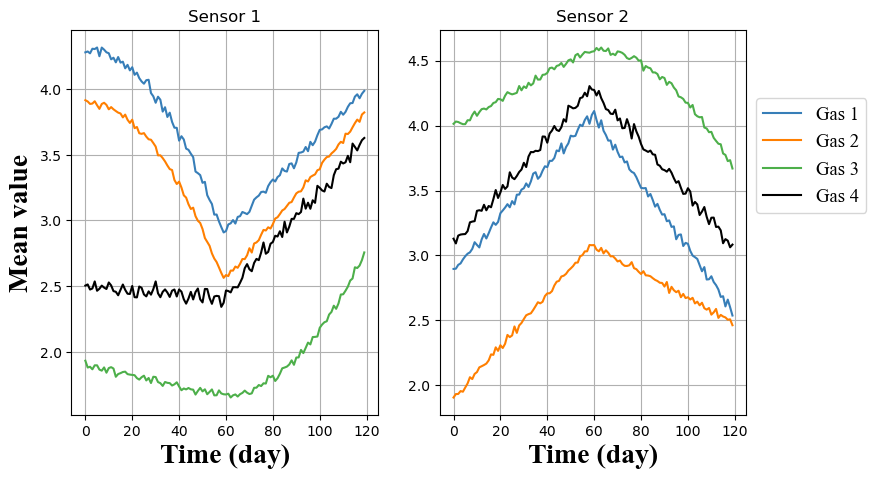

In [47]:
avgs_s1 = zeros(4,n_days)
avgs_s2 = zeros(4,n_days)

for i in 1:120
    samples_day = samples_drift[t.==i, :]
    labels_day = labels_drift[t.==i]
    for label in 1:4
        target = samples_day[labels_day.==label, :]
        target = mean(target, dims = 1);
        avgs_s1[label, i] = target[1]
        avgs_s2[label, i] = target[2]
    end
end


figure(figsize=(10,5))

subplot(121)
plot(avgs_s1[1,:], color = "#377eb8")
hold 
plot(avgs_s1[2,:], color =  "#ff7f00")
plot(avgs_s1[3,:], color = "#4daf4a")
plot(avgs_s1[4,:], color="black")
xlabel("Time (day)", fontsize=20,  fontname="Times New Roman", fontweight="bold")
ylabel("Mean value", fontsize=20,  fontname="Times New Roman", fontweight="bold")
#legend(["Gas 1", "Gas 2", "Gas 3", "Gas 4"],  prop=Dict("family"=>"Times New Roman" ,"size"=>13.5), loc="lower left", bbox_to_anchor=(1, 0.5))
grid("on")
title("Sensor 1")
gcf()[:subplots_adjust](right=0.8) 

subplot(122)
plot(avgs_s2[1,:], color = "#377eb8")
hold 
plot(avgs_s2[2,:], color =  "#ff7f00")
plot(avgs_s2[3,:], color = "#4daf4a")
plot(avgs_s2[4,:], color="black")
xlabel("Time (day)", fontsize=20,  fontname="Times New Roman", fontweight="bold")
#ylabel("Mean value", fontsize=20,  fontname="Times New Roman", fontweight="bold")
legend(["Gas 1", "Gas 2", "Gas 3", "Gas 4"],  prop=Dict("family"=>"Times New Roman" ,"size"=>13.5), loc="lower left", bbox_to_anchor=(1, 0.5))
grid("on")
title("Sensor 2")
gcf()[:subplots_adjust](right=0.8) 

display(gcf())


We now scatter the points from both the driftless and the drifted dataset to illustrate how drift compromises class separability.

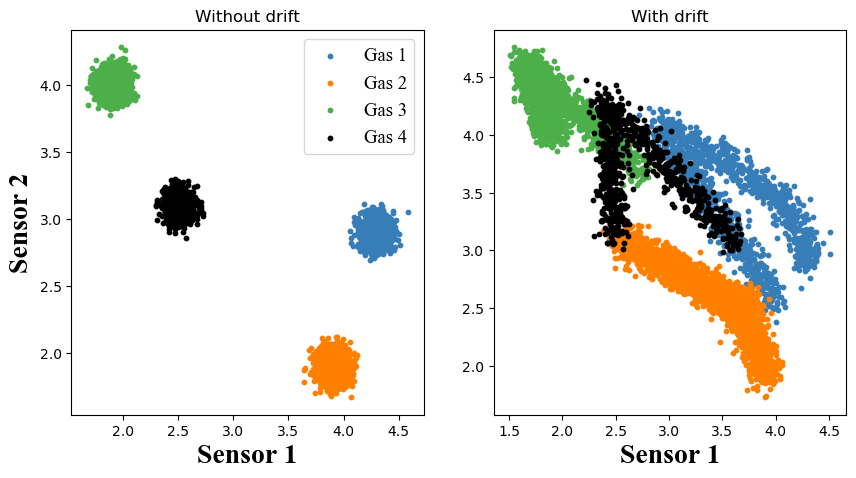

In [48]:

figure(figsize=(10,5))

subplot(121)
scatter(samples_no_drift[labels_no_drift.==1, 1],samples_no_drift[labels_no_drift.==1, 2], color = "#377eb8", s=10)
hold 
scatter(samples_no_drift[labels_no_drift.==2, 1],samples_no_drift[labels_no_drift.==2, 2], color = "#ff7f00", s=10)
scatter(samples_no_drift[labels_no_drift.==3, 1],samples_no_drift[labels_no_drift.==3, 2], color = "#4daf4a", s=10)
scatter(samples_no_drift[labels_no_drift.==4, 1],samples_no_drift[labels_no_drift.==4, 2], color = "black", s=10)
xlabel("Sensor 1", fontsize=20,  fontname="Times New Roman", fontweight="bold")
ylabel("Sensor 2", fontsize=20,  fontname="Times New Roman", fontweight="bold")
legend(["Gas 1", "Gas 2", "Gas 3", "Gas 4"],  prop=Dict("family"=>"Times New Roman" ,"size"=>13.5))
title("Without drift")

subplot(122)
scatter(samples_drift[labels_drift.==1, 1],samples_drift[labels_drift.==1, 2], color = "#377eb8", s=10)
hold 
scatter(samples_drift[labels_drift.==2, 1],samples_drift[labels_drift.==2, 2], color = "#ff7f00", s=10)
scatter(samples_drift[labels_drift.==3, 1],samples_drift[labels_drift.==3, 2], color = "#4daf4a", s=10)
scatter(samples_drift[labels_drift.==4, 1],samples_drift[labels_drift.==4, 2], color = "black", s=10)
xlabel("Sensor 1", fontsize=20,  fontname="Times New Roman", fontweight="bold")
#ylabel("Sensor 2", fontsize=20,  fontname="Times New Roman", fontweight="bold")
#legend(["Gas 1", "Gas 2", "Gas 3", "Gas 4"],  prop=Dict("family"=>"Times New Roman" ,"size"=>13.5))
title("With drift")

display(gcf())

In contrast, we now scatter their $\zeta-$ domain counterparts to show that, in this domain, the data remains nearly undistorted even with the introduction of drift. 

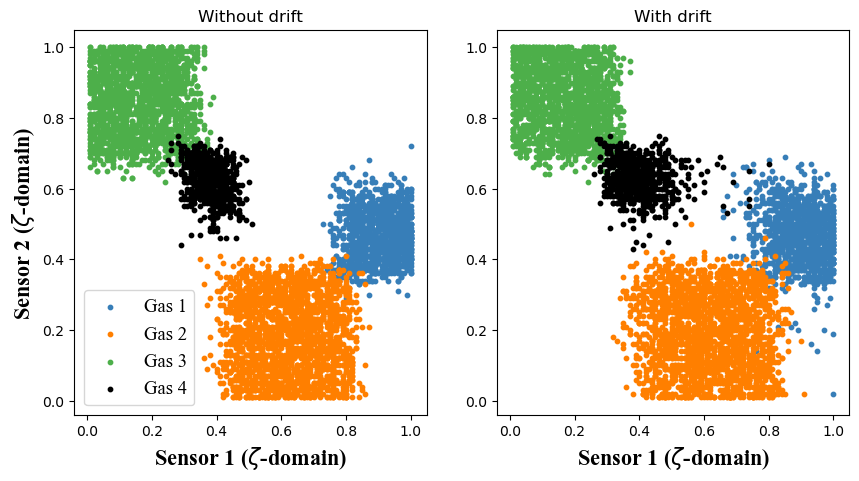

In [49]:
K = 100
samples_zeta_no_drift = project_to_zeta(samples_no_drift, K)
samples_zeta_with_drift = project_to_zeta(samples_drift, K)

figure(figsize=(10,5))

subplot(121)
scatter(samples_zeta_no_drift[labels_no_drift.==1, 1],samples_zeta_no_drift[labels_no_drift.==1, 2], color = "#377eb8", s=10)
hold 
scatter(samples_zeta_no_drift[labels_no_drift.==2, 1],samples_zeta_no_drift[labels_no_drift.==2, 2],color =  "#ff7f00", s=10)
scatter(samples_zeta_no_drift[labels_no_drift.==3, 1],samples_zeta_no_drift[labels_no_drift.==3, 2], color = "#4daf4a", s=10)
scatter(samples_zeta_no_drift[labels_no_drift.==4, 1],samples_zeta_no_drift[labels_no_drift.==4, 2], color = "black", s=10)
xlabel("Sensor 1 ("*L"\zeta"*"-domain)", fontsize=16,  fontname="Times New Roman", fontweight="bold")
ylabel("Sensor 2 ("*L"\zeta"*"-domain)", fontsize=16,  fontname="Times New Roman", fontweight="bold")
legend(["Gas 1", "Gas 2", "Gas 3", "Gas 4"],  prop=Dict("family"=>"Times New Roman" ,"size"=>13.5))
title("Without drift")

subplot(122)
scatter(samples_zeta_with_drift[labels_drift.==1, 1],samples_zeta_with_drift[labels_drift.==1, 2], color = "#377eb8", s=10)
hold 
scatter(samples_zeta_with_drift[labels_drift.==2, 1],samples_zeta_with_drift[labels_drift.==2, 2], color =  "#ff7f00", s=10)
scatter(samples_zeta_with_drift[labels_drift.==3, 1],samples_zeta_with_drift[labels_drift.==3, 2], color = "#4daf4a", s=10)
scatter(samples_zeta_with_drift[labels_drift.==4, 1],samples_zeta_with_drift[labels_drift.==4, 2],  color = "black", s=10)
xlabel("Sensor 1 ("*L"\zeta"*"-domain)", fontsize=16,  fontname="Times New Roman", fontweight="bold")
#ylabel("Sensor 2 ("*L"\zeta"*"-domain)", fontsize=16,  fontname="Times New Roman", fontweight="bold")
#legend(["Gas 1", "Gas 2", "Gas 3", "Gas 4"],  prop=Dict("family"=>"Times New Roman" ,"size"=>13.5))
title("With drift")

display(gcf())



We now redefined the drift pattern in way the the monotonicity hypothesis fails, and show how that compromises the class separability in the $\zeta-$ domain.

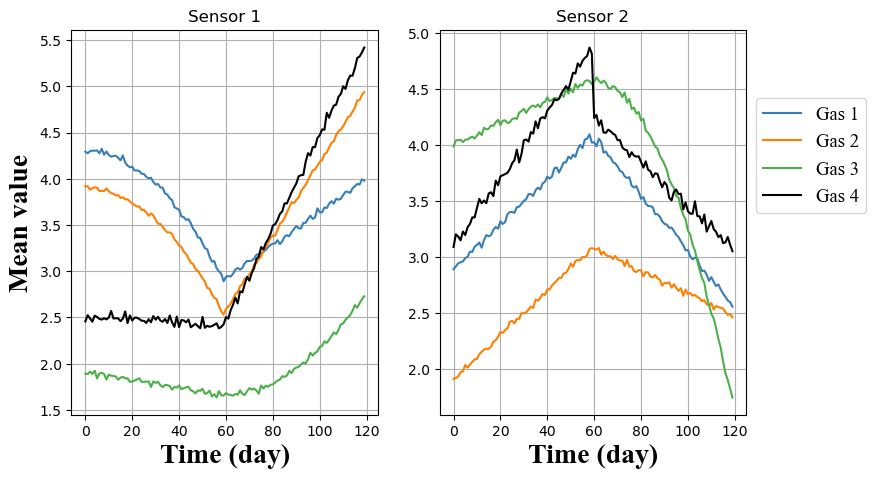

In [50]:
#NEW DRIFT PATTERN
function sample(gas, t) 
    std = 0.07;

    if gas == 1
        mu1 = 4.3;
        mu2 = 2.9;
        s1 = std*randn()+mu1;
        s2 = std*randn()+mu2;
        if t<60
            s1 = s1 - 0.0004*t^2;
            s2 = s2 + 0.02*t;
        end

        if t >=60
            s1 = s1 - 0.0004*59^2 + (t-59)*0.018;
            s2 = s2 + 0.02*59 - (t-59)*0.025;
        end
    end

    if gas == 2
        mu1 = 3.9;
        mu2 = 1.9;
        s1 = std*randn()+mu1;
        s2 = std*randn()+mu2;
        if t<60
            s1 = s1 - 0.00039*t^2;
            s2 = s2 + 0.02*t;
        end
        
        if t>=60
            s1 = s1 - 0.00039*59^2 + (t-59)*0.04;
            s2 = s2 + 0.02*59 - (t-59)*0.01;
        end
    end

    if gas == 3 
        mu1 = 1.9
        mu2 = 4.0
        s1 = std*randn()+mu1;
        s2 = std*randn()+mu2;
        if t<60
            s1 = s1 - 0.004*t;
            s2 = s2 + 0.01*t;
        end

        if t>=60
            s1 = s1 - 0.004*59 + 0.0003*(t-59)^2
            s2 = s2 + 0.01*59 - 0.0008*(t-59)^2
        end
    end

    if gas == 4
        mu1 = 2.5
        mu2 = 3.1
        s1 = std*randn()+mu1;
        s2 = std*randn()+mu2;
        if t<60
            s1 = s1 - 0.0015*t;
            s2 = s2 + 0.03*t;
        end
        
        if t>=60
            s1 = s1 - 0.0015*59 + (t-59)*0.05
            s2 = s2 + 0.02*59 - (t-59)*0.02
        end
    end
    return s1, s2
end

#SIMULATING THE NEW DRIFT PATTERN
samples_drift, labels_drift = simulate_HMM(P, n_days, samples_per_day); #drift dataset


#EVALUATING HOW THE NEW DRIFT PATTERN CHANGES THE SENSORS' RESPONSES OVER THE DAYS
avgs_s1 = zeros(4,n_days)
avgs_s2 = zeros(4,n_days)

for i in 1:120
    samples_day = samples_drift[t.==i, :]
    labels_day = labels_drift[t.==i]
    for label in 1:4
        target = samples_day[labels_day.==label, :]
        target = mean(target, dims = 1);
        avgs_s1[label, i] = target[1]
        avgs_s2[label, i] = target[2]
    end
end


figure(figsize=(10,5))

subplot(121)
plot(avgs_s1[1,:], color = "#377eb8")
hold 
plot(avgs_s1[2,:], color =  "#ff7f00")
plot(avgs_s1[3,:], color = "#4daf4a")
plot(avgs_s1[4,:], color="black")
xlabel("Time (day)", fontsize=20,  fontname="Times New Roman", fontweight="bold")
ylabel("Mean value", fontsize=20,  fontname="Times New Roman", fontweight="bold")
#legend(["Gas 1", "Gas 2", "Gas 3", "Gas 4"],  prop=Dict("family"=>"Times New Roman" ,"size"=>13.5), loc="lower left", bbox_to_anchor=(1, 0.5))
grid("on")
title("Sensor 1")
gcf()[:subplots_adjust](right=0.8) 

subplot(122)
plot(avgs_s2[1,:], color = "#377eb8")
hold 
plot(avgs_s2[2,:], color =  "#ff7f00")
plot(avgs_s2[3,:], color = "#4daf4a")
plot(avgs_s2[4,:], color="black")
xlabel("Time (day)", fontsize=20,  fontname="Times New Roman", fontweight="bold")
#ylabel("Mean value", fontsize=20,  fontname="Times New Roman", fontweight="bold")
legend(["Gas 1", "Gas 2", "Gas 3", "Gas 4"],  prop=Dict("family"=>"Times New Roman" ,"size"=>13.5), loc="lower left", bbox_to_anchor=(1, 0.5))
grid("on")
title("Sensor 2")
gcf()[:subplots_adjust](right=0.8) 

display(gcf())


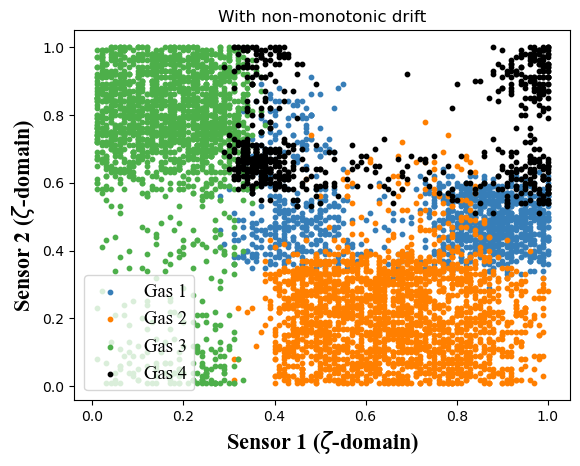

In [51]:
#PROJECTING THE NEW DRIFTED DATASET ONTO THE ZETA-DOMAIN
samples_zeta_with_drift = project_to_zeta(samples_drift, K)

#SCATTERING ITS DATA POINTS

figure()
scatter(samples_zeta_with_drift[labels_drift.==1, 1],samples_zeta_with_drift[labels_drift.==1, 2], color = "#377eb8", s=10)
hold 
scatter(samples_zeta_with_drift[labels_drift.==2, 1],samples_zeta_with_drift[labels_drift.==2, 2], color =  "#ff7f00", s=10)
scatter(samples_zeta_with_drift[labels_drift.==3, 1],samples_zeta_with_drift[labels_drift.==3, 2], color = "#4daf4a", s=10)
scatter(samples_zeta_with_drift[labels_drift.==4, 1],samples_zeta_with_drift[labels_drift.==4, 2],  color = "black", s=10)
xlabel("Sensor 1 ("*L"\zeta"*"-domain)", fontsize=16,  fontname="Times New Roman", fontweight="bold")
ylabel("Sensor 2 ("*L"\zeta"*"-domain)", fontsize=16,  fontname="Times New Roman", fontweight="bold")
legend(["Gas 1", "Gas 2", "Gas 3", "Gas 4"],  prop=Dict("family"=>"Times New Roman" ,"size"=>13.5))
title("With non-monotonic drift")
display(gcf())